In [19]:
import random,string, math,csv
import pandas as pd 
import matplotlib.pyplot as plt
from  sklearn.preprocessing  import  StandardScaler 
import pylab
from sklearn.decomposition import PCA
from sklearn import tree
import graphviz 
import numpy as np
from sklearn import dummy
from sklearn import svm
from sklearn import linear_model
from matplotlib import cm as cm
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from statistics import mean

In [20]:
file = "atlas-higgs-challenge-2014-v2.csv"
df = pd.read_csv(file)
#print(df)

In [21]:
lab = df['Label'].copy()
df = df.drop('Label', 1).copy()
df = df.drop('EventId', 1).copy()
df = df.drop('KaggleSet', 1).copy()
df = df.drop('KaggleWeight', 1).copy()
#print(lab)

In [22]:
weight = df['Weight']

In [23]:
df = df.drop('Weight', 1).copy()

In [24]:
features = df.columns
x = df.values
y = lab.values

In [25]:
w=weight.values
y_weight=np.concatenate (([y],[w]),axis=0)
y_weight=y_weight.T

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y_weight, test_size=0.2, random_state=0)

In [27]:
tmp=Y_train.T
W_train = tmp[1]
Y_train=tmp[0]

tmp=Y_test.T
W_test = tmp[1]
Y_test=tmp[0]

In [28]:
Y_train[Y_train=='b']=-1
Y_train[Y_train=='s']=1
Y_test[Y_test=='b']=-1
Y_test[Y_test=='s']=1

In [29]:
Y_train= Y_train.astype(int)
Y_test= Y_test.astype(int)

In [30]:
%store -r

création du cross val

In [31]:
ind_cross= np.arange(len(Y_train))
random.shuffle(ind_cross)
ind_cross=ind_cross.reshape(5,130918)

In [14]:
%store ind_cross

Stored 'ind_cross' (ndarray)


score AMS

In [32]:
def scoreAMS(y, ypred, w):
    #ypred=yhat.copy()
    #yred[ypred=='s']=1
    #yred[ypred=='b']=-1
    #vrai positifs
    tmp = y.copy()
    tmp[tmp==-1]=0
    tmp=tmp*w
    s=ypred*tmp
    s=sum(s[s>0])
    
    #faux positifs
    tmp = y.copy()
    tmp[tmp==1]=0
    tmp=tmp*w
    b=ypred*tmp
    b=sum(b[b<0])
    b = -1*b
    return  math.sqrt (2.*( (s + b + 10.)*math.log(1.+s/(b+10.))-s))

arbre de décision

In [19]:
acc_a = []
acc_v = []
ams_a = []
ams_v = []
scaler  =  StandardScaler () 
for i in range(2, 35, 4):
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=i, class_weight='balanced')
    acc_c_a = []
    acc_c_v = []
    ams_c_a = []
    ams_c_v = []
    for c in range (len(ind_cross)):
        # création des ensembles d'apprentissage et de validation
        i_v = ind_cross[c]
        i_a = list(set(np.arange(len(Y_train)))-set(i_v))
        x_v = X_train[i_v]
        y_v = Y_train[i_v]
        w_v = W_train[i_v]
        
        x_a = X_train[i_a]
        y_a = Y_train[i_a]
        w_a = W_train[i_a]
        
        # normalisation 
        scaler.fit(x_v)
        x_v = scaler.transform(x_v)
        
        scaler.fit(x_a)
        x_a = scaler.transform(x_a)
        
        # apprentissage
        clf.fit(x_a, y_a)
        
        # score accuracy
        acc_c_a.append(clf.score(x_a,y_a))
        acc_c_v.append(clf.score(x_v,y_v))
        
        # score AMS 
        y_a_pred = clf.predict(x_a)
        ams_c_a.append(scoreAMS(y_a, y_a_pred, w_a))
        y_v_pred = clf.predict(x_v)
        ams_c_v.append(scoreAMS(y_v, y_v_pred, w_v))
      
    # moyenne des score en cross validation
    acc_a.append(mean(acc_c_a))
    acc_v.append(mean(acc_c_v))
    ams_a.append(mean(ams_c_a))
    ams_v.append(mean(ams_c_v))
        

In [20]:
print ('acc_a',acc_a)
print ('acc_v',acc_v)
print ('ams_a',ams_a)
print ('ams_v',ams_v)

acc_a [0.75477818176263, 0.7988385859851205, 0.8175758871965658, 0.8384679723185505, 0.8767709558655036, 0.9235292320383751, 0.95992835209826, 0.9823187033104691, 0.9931911578239814]
acc_v [0.7541499259078202, 0.7938709726699156, 0.8026535694098595, 0.7965764829893521, 0.7843062069386945, 0.7738370583113093, 0.7678287172123008, 0.764006477336959, 0.7617776012465818]
ams_a [1.523584410100634, 1.7801442753288197, 1.9244828427315843, 2.0582297299164036, 2.3584305314656633, 3.0243288942351207, 4.165128036557758, 6.237911537740594, 9.756549078573787]
ams_v [0.7608333743523029, 0.8812706207944349, 0.9269980865899133, 0.9061129334803277, 0.8534967084724508, 0.8063268458393281, 0.7718738537490908, 0.7493711818451665, 0.7362898126246878]


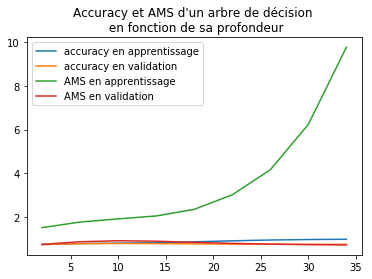

In [21]:
plt.plot(range(2, 35, 4),acc_a, label="accuracy en apprentissage")
plt.plot(range(2, 35, 4),acc_v, label="accuracy en validation")
plt.plot(range(2, 35, 4),ams_a, label="AMS en apprentissage")
plt.plot(range(2, 35, 4),ams_v, label="AMS en validation")
plt.title("Accuracy et AMS d'un arbre de décision \n en fonction de sa profondeur")
plt.legend()
plt.show()

In [23]:
p = pd.DataFrame(np.array([acc_a, acc_v, ams_a, ams_v]).T, columns=['acc train', 'acc val', 'ams train', 'ams val'], index=range(2, 35, 4))
p

,acc train,acc val,ams train,ams val
2,0.754778,0.754150,1.523584,0.760833
6,0.798839,0.793871,1.780144,0.881271
10,0.817576,0.802654,1.924483,0.926998
14,0.838468,0.796576,2.058230,0.906113
18,0.876771,0.784306,2.358431,0.853497
22,0.923529,0.773837,3.024329,0.806327
26,0.959928,0.767829,4.165128,0.771874
30,0.982319,0.764006,6.237912,0.749371
34,0.993191,0.761778,9.756549,0.736290


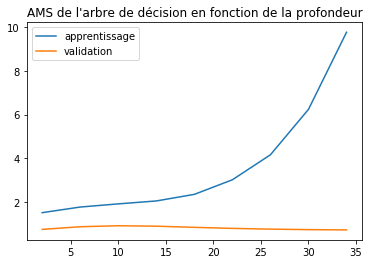

In [22]:
plt.plot(range(2,35,4), [1.523584, 1.780144, 1.924483, 2.058230, 2.358431, 3.024329, 4.165128, 6.237912, 9.756549], label="apprentissage")
plt.plot(range(2,35,4), [0.760833, 0.881271, 0.926998, 0.906113, 0.853497, 0.806327, 0.771874, 0.749371, 0.736290], label="validation")
plt.title("AMS de l'arbre de décision en fonction de la profondeur")
plt.legend()
plt.show()

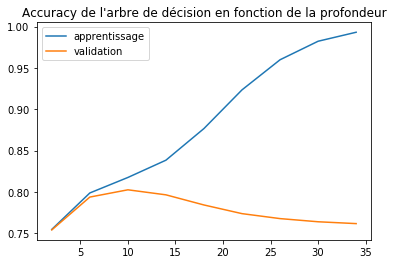

In [21]:
plt.plot(range(2,35,4), [0.754778, 0.798839, 0.817576, 0.838468, 0.876771, 0.923529, 0.959928, 0.982319, 0.993191], label="apprentissage")
plt.plot(range(2,35,4), [0.754150, 0.793871, 0.802654, 0.796576, 0.784306, 0.773837, 0.767829, 0.764006, 0.761778], label="validation")
plt.title("Accuracy de l'arbre de décision en fonction de la profondeur")
plt.legend()
plt.show()

In [ ]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=10, class_weight='balanced')
clf.fit(X_train, Y_train)
print("accuracy test", clf.score(X_test, Y_test))
y_v_pred = clf.predict(x_v)
print("ams test", scoreAMS(Y_test, y_v_pred, W_test)

Régression logistique

l1

In [24]:
acc_a_reg_l1 = []
acc_v_reg_l1 = []
ams_a_reg_l1 = []
ams_v_reg_l1 = []
scaler  =  StandardScaler () 
for c in [ 0.01, 0.1, 1, 10, 50]:
    clf = linear_model.LogisticRegression(penalty='l1', C=c, class_weight='balanced', random_state=0)
    acc_c_a = []
    acc_c_v = []
    ams_c_a = []
    ams_c_v = []
    for c in range (len(ind_cross)):
        # création des ensembles d'apprentissage et de validation
        i_v = ind_cross[c]
        i_a = list(set(np.arange(len(Y_train)))-set(i_v))
        x_v = X_train[i_v]
        y_v = Y_train[i_v]
        w_v = W_train[i_v]
        
        x_a = X_train[i_a]
        y_a = Y_train[i_a]
        w_a = W_train[i_a]
        
        # normalisation 
        scaler.fit(x_v)
        x_v = scaler.transform(x_v)
        
        scaler.fit(x_a)
        x_a = scaler.transform(x_a)
        
        # apprentissage
        clf.fit(x_a, y_a)
        
        # score accuracy
        acc_c_a.append(clf.score(x_a,y_a))
        acc_c_v.append(clf.score(x_v,y_v))
        
        # score AMS 
        y_a_pred = clf.predict(x_a)
        ams_c_a.append(scoreAMS(y_a, y_a_pred, w_a))
        y_v_pred = clf.predict(x_v)
        ams_c_v.append(scoreAMS(y_v, y_v_pred, w_v))
      
    # moyenne des score en cross validation
    acc_a_reg_l1.append(mean(acc_c_a))
    acc_v_reg_l1.append(mean(acc_c_v))
    ams_a_reg_l1.append(mean(ams_c_a))
    ams_v_reg_l1.append(mean(ams_c_v))

In [21]:
print ('acc_a_reg_l1',acc_a_reg_l1)
print ('acc_v_reg_l1',acc_v_reg_l1)
print ('ams_a_reg_l1',ams_a_reg_l1)
print ('ams_v_reg_l1',ams_v_reg_l1)

acc_a_reg_l1 [0.73502459554835853, 0.73515368398539538, 0.73515215631158437, 0.73515253823003712, 0.73515253823003712]
acc_v_reg_l1 [0.73497303655723434, 0.73511052720023218, 0.73508761209306583, 0.73508150139782158, 0.73508608441925483]
ams_a_reg_l1 [1.6137858847288433, 1.61360408926273, 1.6137681717236003, 1.6137768449645036, 1.6137687754271142]
ams_v_reg_l1 [0.8065033443251358, 0.806365996927646, 0.8063771399171784, 0.8063054251754881, 0.8063621168180747]


In [20]:
"""%store acc_a_reg_l1
%store acc_v_reg_l1
%store ams_a_reg_l1
%store ams_v_reg_l1"""

Stored 'acc_a_reg_l1' (list)
Stored 'acc_v_reg_l1' (list)
Stored 'ams_a_reg_l1' (list)
Stored 'ams_v_reg_l1' (list)


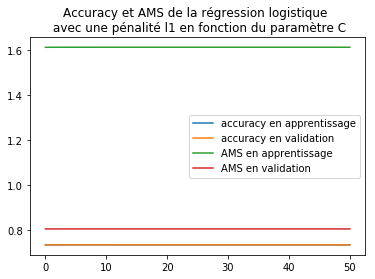

In [27]:
plt.plot([ 0.01, 0.1, 1, 10, 50],acc_a_reg_l1, label="accuracy en apprentissage")
plt.plot([ 0.01, 0.1, 1, 10, 50],acc_v_reg_l1, label="accuracy en validation")
plt.plot([ 0.01, 0.1, 1, 10, 50],ams_a_reg_l1, label="AMS en apprentissage")
plt.plot([ 0.01, 0.1, 1, 10, 50],ams_v_reg_l1, label="AMS en validation")
plt.title("Accuracy et AMS de la régression logistique \n avec une pénalité l1 en fonction du paramètre C")
plt.legend()
plt.show()

In [28]:
p_reg_l1 = pd.DataFrame(np.array([acc_a_reg_l1, acc_v_reg_l1, ams_a_reg_l1, ams_v_reg_l1]).T, columns=['acc train', 'acc val', 'ams train', 'ams val'], index=np.array([ 0.01, 0.1, 1, 10, 50]))
p_reg_l1

,acc train,acc val,ams train,ams val
0.01,0.735038,0.734923,1.613963,0.806232
0.10,0.735146,0.734999,1.613773,0.805979
1.00,0.735170,0.735011,1.613987,0.806047
10.00,0.735165,0.735031,1.614064,0.806116
50.00,0.735166,0.735019,1.614061,0.806095


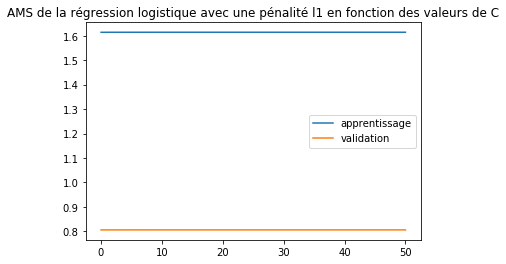

In [18]:
plt.plot([0.01, 0.1, 1, 10, 50], [1.613963, 1.613773, 1.613987, 1.614064, 1.614061], label="apprentissage")
plt.plot([0.01, 0.1, 1, 10, 50], [0.806232, 0.805979, 0.806047, 0.806116, 0.806095], label="validation")
plt.title("AMS de la régression logistique avec une pénalité l1 en fonction des valeurs de C")
plt.legend()
plt.show()

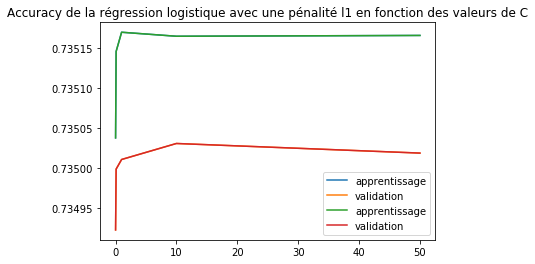

In [17]:
plt.plot([0.01, 0.1, 1, 10, 50], [0.735038, 0.735146, 0.735170, 0.735165, 0.735166], label="apprentissage")
plt.plot([0.01, 0.1, 1, 10, 50], [0.734923, 0.734999, 0.735011, 0.735031, 0.735019], label="validation")
plt.title("Accuracy de la régression logistique avec une pénalité l1 en fonction des valeurs de C")
plt.legend()
plt.show()

l2

In [29]:
acc_a_reg_l2 = []
acc_v_reg_l2 = []
ams_a_reg_l2 = []
ams_v_reg_l2 = []
scaler  =  StandardScaler () 
for c in [ 0.01, 0.1, 1, 10, 50]:
    clf = linear_model.LogisticRegression(penalty='l2', C=c, class_weight='balanced', random_state=0)
    acc_c_a = []
    acc_c_v = []
    ams_c_a = []
    ams_c_v = []
    for c in range (len(ind_cross)):
        # création des ensembles d'apprentissage et de validation
        i_v = ind_cross[c]
        i_a = list(set(np.arange(len(Y_train)))-set(i_v))
        x_v = X_train[i_v]
        y_v = Y_train[i_v]
        w_v = W_train[i_v]
        
        x_a = X_train[i_a]
        y_a = Y_train[i_a]
        w_a = W_train[i_a]
        
        # normalisation 
        scaler.fit(x_v)
        x_v = scaler.transform(x_v)
        
        scaler.fit(x_a)
        x_a = scaler.transform(x_a)
        
        # apprentissage
        clf.fit(x_a, y_a)
        
        # score accuracy
        acc_c_a.append(clf.score(x_a,y_a))
        acc_c_v.append(clf.score(x_v,y_v))
        
        # score AMS 
        y_a_pred = clf.predict(x_a)
        ams_c_a.append(scoreAMS(y_a, y_a_pred, w_a))
        y_v_pred = clf.predict(x_v)
        ams_c_v.append(scoreAMS(y_v, y_v_pred, w_v))
      
    # moyenne des score en cross validation
    acc_a_reg_l2.append(mean(acc_c_a))
    acc_v_reg_l2.append(mean(acc_c_v))
    ams_a_reg_l2.append(mean(ams_c_a))
    ams_v_reg_l2.append(mean(ams_c_v))


In [15]:
print ('acc_a_reg_l2',acc_a_reg_l2)
print ('acc_v_reg_l2',acc_v_reg_l2)
print ('ams_a_reg_l2',ams_a_reg_l2)
print ('ams_v_reg_l2',ams_v_reg_l2)

acc_a_reg_l2 [0.73508264715317984, 0.73514986480086775, 0.73516055851754536, 0.73516781496814798, 0.73520638873187805]
acc_v_reg_l2 [0.73506622465971061, 0.73511816556928766, 0.73509830580974356, 0.73506622465971072, 0.73512885928596527]
ams_a_reg_l2 [1.6130908226449476, 1.6136888386877302, 1.6137839715627975, 1.613751858179457, 1.6136032077773814]
ams_v_reg_l2 [0.8063030934353601, 0.8064557074796359, 0.806441834594776, 0.8063735105160242, 0.8063294205008137]


In [16]:
"""%store acc_a_reg_l2
%store acc_v_reg_l2
%store ams_a_reg_l2
%store ams_v_reg_l2"""

Stored 'acc_a_reg_l2' (list)
Stored 'acc_v_reg_l2' (list)
Stored 'ams_a_reg_l2' (list)
Stored 'ams_v_reg_l2' (list)


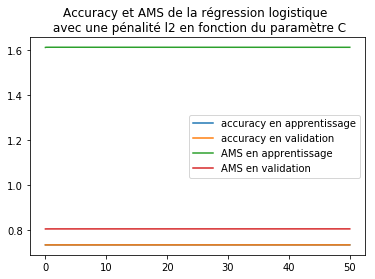

In [30]:
plt.plot([ 0.01, 0.1, 1, 10, 50],acc_a_reg_l2, label="accuracy en apprentissage")
plt.plot([ 0.01, 0.1, 1, 10, 50],acc_v_reg_l2, label="accuracy en validation")
plt.plot([ 0.01, 0.1, 1, 10, 50],ams_a_reg_l2, label="AMS en apprentissage")
plt.plot([ 0.01, 0.1, 1, 10, 50],ams_v_reg_l2, label="AMS en validation")
plt.title("Accuracy et AMS de la régression logistique \n avec une pénalité l2 en fonction du paramètre C")
plt.legend()
plt.show()

In [31]:
p_reg_l2 = pd.DataFrame(np.array([acc_a_reg_l2, acc_v_reg_l2, ams_a_reg_l2, ams_v_reg_l2]).T, columns=['acc train', 'acc val', 'ams train', 'ams val'], index=[ 0.01, 0.1, 1, 10, 50])
p_reg_l2

,acc train,acc val,ams train,ams val
0.01,0.735073,0.735001,1.613163,0.805926
0.10,0.735166,0.735013,1.613926,0.806101
1.00,0.735175,0.735025,1.614009,0.806192
10.00,0.735172,0.735078,1.613934,0.806228
50.00,0.735191,0.735075,1.613794,0.806300


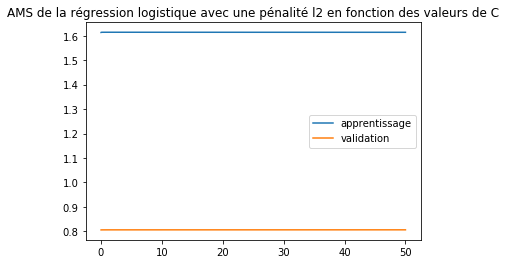

In [20]:
plt.plot([0.01, 0.1, 1, 10, 50], [1.613163, 1.613926, 1.614009, 1.613934, 1.613794], label="apprentissage")
plt.plot([0.01, 0.1, 1, 10, 50], [0.805926, 0.806101, 0.806192, 0.806228, 0.806300], label="validation")
plt.title("AMS de la régression logistique avec une pénalité l2 en fonction des valeurs de C")
plt.legend()
plt.show()

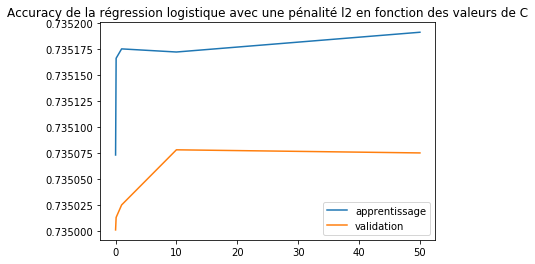

In [19]:
plt.plot([0.01, 0.1, 1, 10, 50], [0.735073, 0.735166, 0.735175, 0.735172, 0.735191], label="apprentissage")
plt.plot([0.01, 0.1, 1, 10, 50], [0.735001, 0.735013, 0.735025, 0.735078, 0.735075], label="validation")
plt.title("Accuracy de la régression logistique avec une pénalité l2 en fonction des valeurs de C")
plt.legend()
plt.show()

Random forest

In [33]:
nb_c=[10, 80, 160, 240, 320]

In [35]:
acc_a_rf = []
acc_v_rf = []
ams_a_rf = []
ams_v_rf = []
scaler  =  StandardScaler () 
nb_features = int(math.sqrt(len(X_train[0])))
for n in nb_c:
    print(n)
    clf =  RandomForestClassifier( max_features= nb_features, n_estimators=n, max_depth=11, class_weight='balanced', random_state=0)
    acc_c_a = []
    acc_c_v = []
    ams_c_a = []
    ams_c_v = []
    for c in range (len(ind_cross)):
        # création des ensembles d'apprentissage et de validation
        i_v = ind_cross[c]
        i_a = list(set(np.arange(len(Y_train)))-set(i_v))
        x_v = X_train[i_v]
        y_v = Y_train[i_v]
        w_v = W_train[i_v]
        
        x_a = X_train[i_a]
        y_a = Y_train[i_a]
        w_a = W_train[i_a]
        
        # normalisation 
        scaler.fit(x_v)
        x_v = scaler.transform(x_v)
        
        scaler.fit(x_a)
        x_a = scaler.transform(x_a)
        
        # apprentissage
        clf.fit(x_a, y_a)
        
        # score accuracy
        acc_c_a.append(clf.score(x_a,y_a))
        acc_c_v.append(clf.score(x_v,y_v))
        
        # score AMS 
        y_a_pred = clf.predict(x_a)
        ams_c_a.append(scoreAMS(y_a, y_a_pred, w_a))
        y_v_pred = clf.predict(x_v)
        ams_c_v.append(scoreAMS(y_v, y_v_pred, w_v))
      
    # moyenne des score en cross validation
    acc_a_rf.append(mean(acc_c_a))
    acc_v_rf.append(mean(acc_c_v))
    ams_a_rf.append(mean(ams_c_a))
    ams_v_rf.append(mean(ams_c_v))


10
80
160
240
320


In [36]:
print ('acc_a_rf',acc_a_rf)
print ('acc_v_rf',acc_v_rf)
print ('ams_a_rf',ams_a_rf)
print ('ams_v_rf',ams_v_rf)

acc_a_rf [0.82433507997372402, 0.82663766632548619, 0.82650781405154372, 0.82653416642478494, 0.82665447073740816]
acc_v_rf [0.8112910371377503, 0.81393085748331018, 0.81393696817855454, 0.81419667272643947, 0.81420125574787272]
ams_a_rf [2.0117767242245717, 2.0323754758678096, 2.0304991579026033, 2.0302598832124588, 2.030785117793113]
ams_v_rf [0.9689370081083024, 0.9776866252439264, 0.9770214070371055, 0.9775540170871149, 0.9771623467545041]


In [22]:
"""%store acc_a_rf
%store acc_v_rf
%store ams_a_rf
%store ams_v_rf"""

Stored 'acc_a_rf' (list)
Stored 'acc_v_rf' (list)
Stored 'ams_a_rf' (list)
Stored 'ams_v_rf' (list)


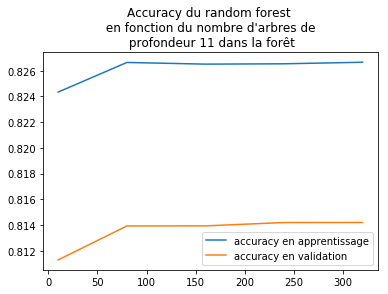

In [40]:
plt.plot(nb_c, acc_a_rf, label= "accuracy en apprentissage")
plt.plot(nb_c, acc_v_rf, label= "accuracy en validation")
plt.title("Accuracy du random forest \n en fonction du nombre d'arbres de \n profondeur 11 dans la forêt")
plt.legend()
plt.show()

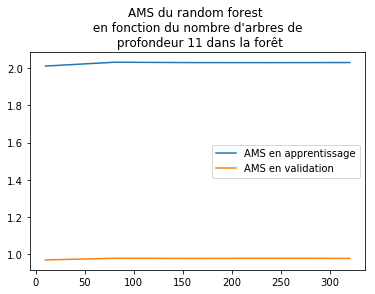

In [41]:
plt.plot(nb_c, ams_a_rf, label= "AMS en apprentissage")
plt.plot(nb_c, ams_v_rf, label= "AMS en validation")
plt.title("AMS du random forest \n en fonction du nombre d'arbres de \n profondeur 11 dans la forêt")
plt.legend()
plt.show()

In [39]:
p_rf = pd.DataFrame(np.array([acc_a_rf, acc_v_rf, ams_a_rf, ams_v_rf]).T, columns=['acc train', 'acc val', 'ams train', 'ams val'], index=nb_c)
p_rf

,acc train,acc val,ams train,ams val
10,0.824335,0.811291,2.011777,0.968937
80,0.826638,0.813931,2.032375,0.977687
160,0.826508,0.813937,2.030499,0.977021
240,0.826534,0.814197,2.030260,0.977554
320,0.826654,0.814201,2.030785,0.977162


adaboost

In [ ]:
acc_a_ab = []
acc_v_ab = []
ams_a_ab = []
ams_v_ab = []
scaler  =  StandardScaler () 
for n in [10,60,110,160,210,260,310]:
    print(n)
    clf =  AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=3), n_estimators=n, random_state=0)
    acc_c_a = []
    acc_c_v = []
    ams_c_a = []
    ams_c_v = []
    for c in range (len(ind_cross)):
        # création des ensembles d'apprentissage et de validation
        i_v = ind_cross[c]
        i_a = list(set(np.arange(len(Y_train)))-set(i_v))
        x_v = X_train[i_v]
        y_v = Y_train[i_v]
        w_v = W_train[i_v]
        
        x_a = X_train[i_a]
        y_a = Y_train[i_a]
        w_a = W_train[i_a]
        
        # normalisation 
        scaler.fit(x_v)
        x_v = scaler.transform(x_v)
        
        scaler.fit(x_a)
        x_a = scaler.transform(x_a)
        
        # apprentissage
        clf.fit(x_a, y_a)
        
        # score accuracy
        acc_c_a.append(clf.score(x_a,y_a))
        acc_c_v.append(clf.score(x_v,y_v))
        
        # score AMS 
        y_a_pred = clf.predict(x_a)
        ams_c_a.append(scoreAMS(y_a, y_a_pred, w_a))
        y_v_pred = clf.predict(x_v)
        ams_c_v.append(scoreAMS(y_v, y_v_pred, w_v))
      
    # moyenne des score en cross validation
    acc_a_ab.append(mean(acc_c_a))
    acc_v_ab.append(mean(acc_c_v))
    ams_a_ab.append(mean(ams_c_a))
    ams_v_ab.append(mean(ams_c_v))

In [ ]:
print ('acc_a_ab',acc_a_ab)
print ('acc_v_ab',acc_v_ab)
print ('ams_a_ab',ams_a_ab)
print ('ams_v_ab',ams_v_ab)

In [ ]:
%store acc_a_ab
%store acc_v_ab
%store ams_a_ab
%store ams_v_ab

In [ ]:
plt.plot([10,40,70,100,130,160,190],acc_a_ab, label="apprentissage")
plt.plot([10,40,70,100,130,160,190],acc_v_ab, label="validation")
plt.title("Accuracy d'adaboost en fonction du nombre de classifieurs")
plt.legend()
plt.show()

In [ ]:
plt.plot([10,40,70,100,130,160,190],ams_a_ab, label="apprentissage")
plt.plot([10,40,70,100,130,160,190],ams_v_ab, label="validation")
plt.title("AMS d'adaboost en fonction du nombre de classifieurs")
plt.legend()
plt.show()

In [ ]:
p_ab = pd.DataFrame(np.array([acc_a_ab, acc_v_ab, ams_a_ab, ams_v_ab]).T, columns=['acc train', 'acc val', 'ams train', 'ams val'], index=[10,40,70,100,130,160,190])
p_ab

In [15]:
pd.DataFrame(np.array([[0.8125, 1.0473], [0.735, 0.893]]))

,0,1
0,0.8125,1.0473
1,0.7350,0.8930


In [18]:
p_final = pd.DataFrame(np.array([[0.8125, 1.0473], [0.735, 0.893]]), columns = ['accuracy', 'ams'], index=["arbre de décision", "régression logistique"])
p_final

,accuracy,ams
arbre de décision,0.8125,1.0473
régression logistique,0.7350,0.8930
